Name: Hanish Sai Rohit
Ph no: 8332082623
email id: hanishsidhu@gmail.com
email id: hanishrohit@gmail.com

<h1 style="text-align:center;font-size:30px;" > Netflix Movie Recommendation  </h1>

<h3>Real world/Business Objectives </h3>

1. Predict the rating that a user would give to a movie that he/she has not yet rated.
2. Minimize the difference between predicted and actual rating (RMSE and MAPE)
<br>

<h3>  Mapping the real world problem to a Machine Learning Problem </h3>

<pre>
For a given movie and user we need to predict the rating would be given by him/her to the movie. 
The given problem is a Recommendation problem 
It can also seen as a Regression problem 
</pre>

# Data Acquisation

In [1]:
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib
from prettytable import PrettyTable
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random
import multiprocessing
from multiprocessing import Process

In [2]:
if not os.path.isfile('data.csv'):
 
    data = open('data.csv', mode='w')
    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']
    for file in files:
        with open(file) as f:
            for line in f: 
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
    data.close()

In [39]:
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)

# arranging the ratings according to time.
df.sort_values(by='date', inplace=True)
df.head(2)

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11


# Data Analyisis and Data Cleaning

In [29]:
x = PrettyTable()
i=0
print('Basic Stats on ratings.')
x.field_names=[ 'metric','value']
for row in df.describe()['rating']:
    x.add_row([df.describe()['rating'].index[i],np.round(row,decimals=2)])
    i = i + 1
print(x)    

Basic Stats on ratings.
+--------+-------------+
| metric |    value    |
+--------+-------------+
| count  | 100480507.0 |
|  mean  |     3.6     |
|  std   |     1.09    |
|  min   |     1.0     |
|  25%   |     3.0     |
|  50%   |     4.0     |
|  75%   |     4.0     |
|  max   |     5.0     |
+--------+-------------+


In [11]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


In [12]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


In [13]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


In [2]:
if not os.path.isfile('train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

In [4]:
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


In [6]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


<h3> Distribution of ratings </h3>

In [26]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

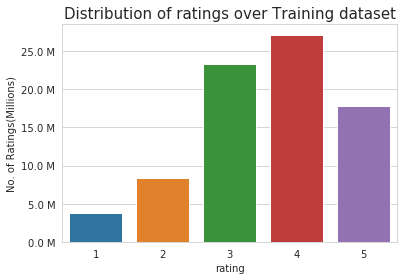

In [11]:
%matplotlib inline

fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')
plt.show()

observation:
    * most of the ratings are either 3 or 4.

In [24]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

train_df['day_of_week'] = train_df.date.dt.weekday_name

train_df.tail(2)

,movie,user,rating,date,day_of_week
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


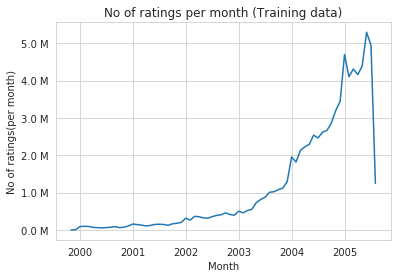

In [13]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

observation:
    * Number of ratings per month increases over the time.

<h3>  Analysis on the Ratings given by user </h3>

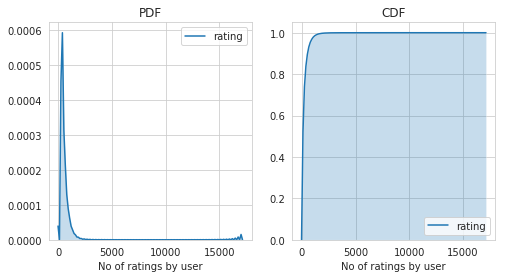

In [4]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [15]:
no_of_rated_movies_per_user.describe()  

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

observation:
    * more than 50% of users have rated more than 89 times.
    * 75% of users have rated less than 245 times.

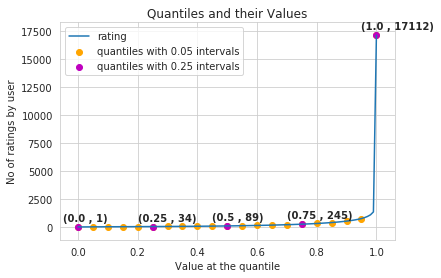

In [19]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(text="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

In [21]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 749)) )


 No of ratings at last 5 percentile : 20305



<h3> Analysis of ratings of a movie given by a user </h3>

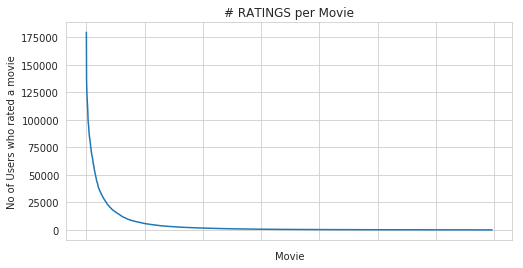

In [22]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

- __It is very skewed.. just like nunmber of ratings given per user.__
    
    
    - There are some movies (which are very popular) which are rated by huge number of users.
    
    - But most of the movies(like 90%) got some hundereds of ratings.

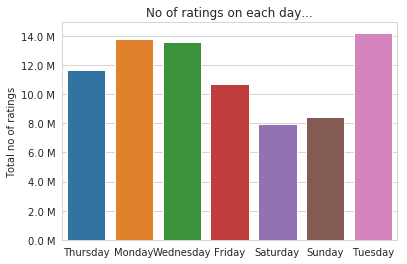

In [27]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

observation:
    * most of the reviews are on weekdays

<h3>  Creating sparse matrix from data frame </h3>

In [28]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
else: 
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('shape of the created sparse matrix (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

shape of the created sparse matrix (user, movie) :  (2649430, 17771)
Saving it into disk for furthur usage..
Done..

0:01:12.092823


<p><b>The Sparsity of Train Sparse Matrix</b></p>

In [29]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.8292709259195 % 


<h4> Creating sparse matrix from test data frame </h4>

In [30]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
else: 
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('shape of the created sparse matrix (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)    
print(datetime.now() - start)

shape of the created sparse matrix (user, movie) :  (2649430, 17771)
Saving it into disk for furthur usage..
0:00:18.908979


<p><b>The Sparsity of Test data Matrix</b></p>

In [31]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


<h3> Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</h3>

In [2]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [33]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

In [35]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.3781094527363185


In [36]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])


 AVerage rating of movie 15 : 3.3038461538461537


<h4>  PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data)</h4>

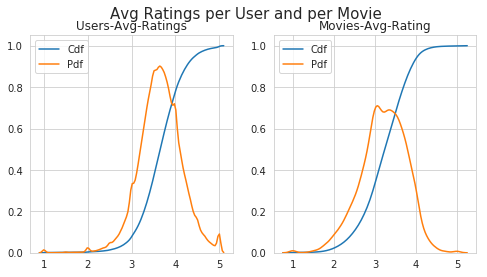

In [37]:
# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
# get the list of average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movies-Avg-Rating')
# get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()

<h3> Cold Start problem </h3>

<h4>  Cold Start problem with Users</h4>

In [40]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


> We might have to handle __new users__ ( ___75148___ ) who didn't appear in train data.

<h4> Cold Start problem with Movies</h4>

In [41]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


> We might have to handle __346 movies__ (small comparatively) in test data

<h3> Computing Movie-Movie Similarity matrix </h3>

In [42]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
else:
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

It's a  (17771, 17771)  dimensional matrix


In [44]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]

# just testing similar movies for movie_15
similar_movies[15]

array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973,  1720,  5370, 16309,  9376,  6116,  4706,  2818,
         778, 15331,  1416, 12979, 17139, 17710,  5452,  2534,   164,
       15188,  8323,  2450, 16331,  9566, 15301, 13213, 14308, 15984,
       10597,  6426,  5500,  7068,  7328,  5720,  9802,   376, 13013,
        8003, 10199,  3338, 15390,  9688, 16455, 11730,  4513,   598,
       12762,  2187,   509,  5865,  9166, 17115, 16334,  1942,  7282,
       17584,  4376,  8988,  8873,  5921,  2716, 14679, 11947, 11981,
        4649,   565, 12954, 10788, 10220, 10963,  9427,  1690,  5107,
        7859,  5969,  1510,  2429,   847,  7845,  6410, 13931,  9840,
        3706])

<h3> Finding most similar movies using similarity matrix </h3>

In [46]:
movie_titles = pd.read_csv("movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head(2)

Tokenization took: 4.66 ms
Type conversion took: 11.94 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review


In [48]:
mv_id = 67

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similar to this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Vampire Journals

It has 270 Ratings from users.

We have 17284 movies which are similar to this  and we will get only top most..


In [49]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:]

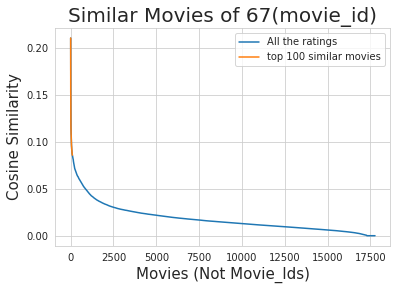

In [50]:
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

In [58]:
x = PrettyTable()
x.field_names=[ '10 most similar movies of Vampire Journals are: ']
for i in sim_indices[:10]:
    x.add_row([movie_titles['title'].loc[i]+"\n"])
print(x)    

+--------------------------------------------------+
| 10 most similar movies of Vampire Journals are:  |
+--------------------------------------------------+
|                 Modern Vampires                  |
|                                                  |
|             Subspecies 4: Bloodstorm             |
|                                                  |
|             To Sleep With a Vampire              |
|                                                  |
|             Dracula: The Dark Prince             |
|                                                  |
|                  Dracula Rising                  |
|                                                  |
|              Vampires: Los Muertos               |
|                                                  |
|                    Vampirella                    |
|                                                  |
|                   Club Vampire                   |
|                                             

 <h1>   Machine Learning Models </h1>

In [18]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

<h2> Sampling Train Data </h2>

In [4]:
if os.path.isfile('train_sparse_matrix.npz'):
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')

In [5]:
sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=25000, no_movies=3000)

Original Matrix : (users, movies) -- (405041 17424)
Original Matrix : Ratings -- 80384405

Sampled Matrix : (users, movies) -- (25000 3000)
Sampled Matrix : Ratings -- 856986
Done..



In [6]:
import pickle as pkl
with open("train_sample.pkl",'wb') as f:
    pkl.dump([sample_train_sparse_matrix],f)

<h2> Featurizing train data </h2>

<h3> Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)</h3>

In [7]:
train_sparse_matrix = sample_train_sparse_matrix
train_averages = dict()
global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = global_average
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)

#### Pre-processing steps for multi threading

In [8]:
tuple_of_user_movie_and_corresponding_rating = sparse.find(train_sparse_matrix)
array_of_user_movie_and_corresponding_rating = np.array( tuple_of_user_movie_and_corresponding_rating )
array_of_user_movie_and_corresponding_rating = array_of_user_movie_and_corresponding_rating.T

#threshold for multiprocessing
threshold= int(np.shape(array_of_user_movie_and_corresponding_rating)[0]/24)

In [10]:
import multiprocessing
from multiprocessing import Process

subset_1 = array_of_user_movie_and_corresponding_rating[0*threshold:1*threshold]
subset_2 = array_of_user_movie_and_corresponding_rating[1*threshold:2*threshold]
subset_3 = array_of_user_movie_and_corresponding_rating[2*threshold:3*threshold]
subset_4 = array_of_user_movie_and_corresponding_rating[3*threshold:4*threshold]
subset_5 = array_of_user_movie_and_corresponding_rating[4*threshold:5*threshold]
subset_6 = array_of_user_movie_and_corresponding_rating[5*threshold:6*threshold]
subset_7 = array_of_user_movie_and_corresponding_rating[6*threshold:7*threshold]
subset_8 = array_of_user_movie_and_corresponding_rating[7*threshold:8*threshold]
subset_9 = array_of_user_movie_and_corresponding_rating[8*threshold:9*threshold]
subset_10 = array_of_user_movie_and_corresponding_rating[9*threshold:10*threshold]
subset_11 = array_of_user_movie_and_corresponding_rating[10*threshold:11*threshold]
subset_12 = array_of_user_movie_and_corresponding_rating[11*threshold:12*threshold]
subset_13 = array_of_user_movie_and_corresponding_rating[12*threshold:13*threshold]
subset_14 = array_of_user_movie_and_corresponding_rating[13*threshold:14*threshold]
subset_15 = array_of_user_movie_and_corresponding_rating[14*threshold:15*threshold]
subset_16 = array_of_user_movie_and_corresponding_rating[15*threshold:16*threshold]
subset_17 = array_of_user_movie_and_corresponding_rating[16*threshold:17*threshold]
subset_18 = array_of_user_movie_and_corresponding_rating[17*threshold:18*threshold]
subset_19 = array_of_user_movie_and_corresponding_rating[18*threshold:19*threshold]
subset_20 = array_of_user_movie_and_corresponding_rating[19*threshold:20*threshold]
subset_21 = array_of_user_movie_and_corresponding_rating[20*threshold:21*threshold]
subset_22= array_of_user_movie_and_corresponding_rating[21*threshold:22*threshold]
subset_23 = array_of_user_movie_and_corresponding_rating[22*threshold:23*threshold]
subset_24 = array_of_user_movie_and_corresponding_rating[23*threshold:]

### featurizing train data by multi threading

In [ ]:
from tqdm import tqdm
from datetime import datetime
import time

def featurizing_train_data(subset,user_user_similairity_dict,movie_movie_similarity_dict,i):
    try :
        
        j = i + 1

        if os.path.isfile('train_csv_files/reg_train'+str(j)+'.csv'):
            print("File already exists you don't have to prepare again..." )
        else:
            with open('train_csv_files/reg_train'+str(j)+'.csv', mode='w') as reg_data_file:
                start = time.time()
                
                for user_movie_rating in tqdm(subset):
                    if time.time()-start >79000 : #runs for 22 hrs
                        break
                    user = user_movie_rating[0]
                    movie = user_movie_rating[1]
                    rating = user_movie_rating[2]
                                    
                    try :
                        top_sim_users = user_user_similairity_dict[user]
                        top_sim_users = np.array(top_sim_users)
                    
                    except KeyError:
            
                        # the similarity of Users of the "user"        
                        user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
                        top_sim_users = user_sim.argsort()[::-1][1:10000]
                        user_user_similairity_dict.update({user: list(top_sim_users)})
                           
                    top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                    top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                    top_sim_users_ratings.extend([train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                                 
                    try :
                        top_sim_movies = movie_movie_similarity_dict[movie]
                        top_sim_movies = np.array(top_sim_movies)
                                     
                    except KeyError:
                    
                        # compute the similar movies of the "movie"        
                        movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
                        top_sim_movies = movie_sim.argsort()[::-1][1:1000] 
                        movie_movie_similarity_dict.update({movie:list(top_sim_movies)})
                               
                    top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                    top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                    top_sim_movies_ratings.extend([train_averages['user'][user]] * (5-len(top_sim_movies_ratings))) 

                    #----------------- stores in a file-----------------#
                    row = list()
                    row.append(user)
                    row.append(movie)
                    row.append(train_averages['global']) # writing features
                    row.extend(top_sim_users_ratings)
                    row.extend(top_sim_movies_ratings)
                    row.append(train_averages['user'][user])
                    row.append(train_averages['movie'][movie])

                    # finally, The actual Rating of this user-movie pair.
                    row.append(rating)

                    reg_data_file.write(','.join(map(str, row)))
                    reg_data_file.write('\n')  
                
                
    except MemoryError:
        print("Memory is full !!!")  

        

def main():
    

    manager = multiprocessing.Manager()
    user_user_similairity_dict = manager.dict({})
    movie_movie_similarity_dict = manager.dict({})
    
    
    
    
    p1  =Process(target=featurizing_train_data,args=(subset_1,user_user_similairity_dict,movie_movie_similarity_dict,0))
    p2  =Process(target=featurizing_train_data,args=(subset_2,user_user_similairity_dict,movie_movie_similarity_dict,1))
    p3  =Process(target=featurizing_train_data,args=(subset_3,user_user_similairity_dict,movie_movie_similarity_dict,2))
    p4  =Process(target=featurizing_train_data,args=(subset_4,user_user_similairity_dict,movie_movie_similarity_dict,3))
    p5  =Process(target=featurizing_train_data,args=(subset_5,user_user_similairity_dict,movie_movie_similarity_dict,4))
    p6  =Process(target=featurizing_train_data,args=(subset_6,user_user_similairity_dict,movie_movie_similarity_dict,5))
    p7  =Process(target=featurizing_train_data,args=(subset_7,user_user_similairity_dict,movie_movie_similarity_dict,6))
    p8  =Process(target=featurizing_train_data,args=(subset_8,user_user_similairity_dict,movie_movie_similarity_dict,7))
    p9  =Process(target=featurizing_train_data,args=(subset_9,user_user_similairity_dict,movie_movie_similarity_dict,8))
    p10  =Process(target=featurizing_train_data,args=(subset_10,user_user_similairity_dict,movie_movie_similarity_dict,9))
    p11  =Process(target=featurizing_train_data,args=(subset_11,user_user_similairity_dict,movie_movie_similarity_dict,10))
    p12  =Process(target=featurizing_train_data,args=(subset_12,user_user_similairity_dict,movie_movie_similarity_dict,11))
    p13  =Process(target=featurizing_train_data,args=(subset_13,user_user_similairity_dict,movie_movie_similarity_dict,12))
    p14  =Process(target=featurizing_train_data,args=(subset_14,user_user_similairity_dict,movie_movie_similarity_dict,13))
    p15  =Process(target=featurizing_train_data,args=(subset_15,user_user_similairity_dict,movie_movie_similarity_dict,14))
    p16  =Process(target=featurizing_train_data,args=(subset_16,user_user_similairity_dict,movie_movie_similarity_dict,15))
    p17  =Process(target=featurizing_train_data,args=(subset_17,user_user_similairity_dict,movie_movie_similarity_dict,16))
    p18  =Process(target=featurizing_train_data,args=(subset_18,user_user_similairity_dict,movie_movie_similarity_dict,17))
    p19  =Process(target=featurizing_train_data,args=(subset_19,user_user_similairity_dict,movie_movie_similarity_dict,18))
    p20  =Process(target=featurizing_train_data,args=(subset_20,user_user_similairity_dict,movie_movie_similarity_dict,19))
    p21  =Process(target=featurizing_train_data,args=(subset_21,user_user_similairity_dict,movie_movie_similarity_dict,20))
    p22  =Process(target=featurizing_train_data,args=(subset_22,user_user_similairity_dict,movie_movie_similarity_dict,21))
    p23  =Process(target=featurizing_train_data,args=(subset_23,user_user_similairity_dict,movie_movie_similarity_dict,22))
    p24  =Process(target=featurizing_train_data,args=(subset_24,user_user_similairity_dict,movie_movie_similarity_dict,23))
    
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    p6.start()
    p7.start()
    p8.start()
    p9.start()
    p10.start()
    p11.start()
    p12.start()
    p13.start()
    p14.start()
    p15.start()
    p16.start()
    p17.start()
    p18.start()
    p19.start()
    p20.start()
    p21.start()
    p22.start()
    p23.start()
    p24.start()
    
    
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()
    p6.join()
    p7.join()
    p8.join()
    p9.join()
    p10.join()
    p11.join()
    p12.join()
    p13.join()
    p14.join()
    p15.join()
    p16.join()
    p17.join()
    p18.join()
    p19.join()
    p20.join()
    p21.join()
    p22.join()
    p23.join()
    p24.join()
    
    return user_user_similairity_dict,movie_movie_similarity_dict

    
            
if __name__ == "__main__" :
    user_user_similairity_dict,movie_movie_similarity_dict = main()

#kernal was lost in GCP   

 13%|█▎        | 4552/35707 [1:20:09<13:13:26,  1.53s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 4964/35707 [1:26:32<10:40:37,  1.25s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▍        | 5259/35707 [1:31:50<7:41:38,  1.10it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`

### featurizing remaining samples of train dataset as the kernal was lost.

In [7]:
import pickle as pkl
with open("train_sample.pkl",'rb') as f:
    [sample_train_sparse_matrix] = pkl.load(f)

In [8]:
train_sparse_matrix = sample_train_sparse_matrix
train_averages = dict()
global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = global_average
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)

### Pre-processing for multi threading.

In [9]:
tuple_of_user_movie_and_corresponding_rating = sparse.find(train_sparse_matrix)
array_of_user_movie_and_corresponding_rating = np.array( tuple_of_user_movie_and_corresponding_rating )
array_of_user_movie_and_corresponding_rating = array_of_user_movie_and_corresponding_rating.T

#threshold for multiprocessing
threshold= int(np.shape(array_of_user_movie_and_corresponding_rating)[0]/24)

In [10]:
import multiprocessing
from multiprocessing import Process

subset_1 = array_of_user_movie_and_corresponding_rating[0*threshold:1*threshold]
subset_2 = array_of_user_movie_and_corresponding_rating[1*threshold:2*threshold]
subset_3 = array_of_user_movie_and_corresponding_rating[2*threshold:3*threshold]
subset_4 = array_of_user_movie_and_corresponding_rating[3*threshold:4*threshold]
subset_5 = array_of_user_movie_and_corresponding_rating[4*threshold:5*threshold]
subset_6 = array_of_user_movie_and_corresponding_rating[5*threshold:6*threshold]
subset_7 = array_of_user_movie_and_corresponding_rating[6*threshold:7*threshold]
subset_8 = array_of_user_movie_and_corresponding_rating[7*threshold:8*threshold]
subset_9 = array_of_user_movie_and_corresponding_rating[8*threshold:9*threshold]
subset_10 = array_of_user_movie_and_corresponding_rating[9*threshold:10*threshold]
subset_11 = array_of_user_movie_and_corresponding_rating[10*threshold:11*threshold]
subset_12 = array_of_user_movie_and_corresponding_rating[11*threshold:12*threshold]
subset_13 = array_of_user_movie_and_corresponding_rating[12*threshold:13*threshold]
subset_14 = array_of_user_movie_and_corresponding_rating[13*threshold:14*threshold]
subset_15 = array_of_user_movie_and_corresponding_rating[14*threshold:15*threshold]
subset_16 = array_of_user_movie_and_corresponding_rating[15*threshold:16*threshold]
subset_17 = array_of_user_movie_and_corresponding_rating[16*threshold:17*threshold]
subset_18 = array_of_user_movie_and_corresponding_rating[17*threshold:18*threshold]
subset_19 = array_of_user_movie_and_corresponding_rating[18*threshold:19*threshold]
subset_20 = array_of_user_movie_and_corresponding_rating[19*threshold:20*threshold]
subset_21 = array_of_user_movie_and_corresponding_rating[20*threshold:21*threshold]
subset_22= array_of_user_movie_and_corresponding_rating[21*threshold:22*threshold]
subset_23 = array_of_user_movie_and_corresponding_rating[22*threshold:23*threshold]
subset_24 = array_of_user_movie_and_corresponding_rating[23*threshold:]

### Retrieving  samples that were not computed due to kernel interruption.

In [12]:
subset_1 = subset_1[pd.read_csv("train_csv_files/reg_train1.csv").shape[0]:]
subset_2 = subset_2[pd.read_csv("train_csv_files/reg_train2.csv").shape[0]:]
subset_3 = subset_3[pd.read_csv("train_csv_files/reg_train3.csv").shape[0]:]
subset_4 = subset_4[pd.read_csv("train_csv_files/reg_train4.csv").shape[0]:]
subset_5 = subset_5[pd.read_csv("train_csv_files/reg_train5.csv").shape[0]:]
subset_6 = subset_6[pd.read_csv("train_csv_files/reg_train6.csv").shape[0]:]
subset_7 = subset_7[pd.read_csv("train_csv_files/reg_train7.csv").shape[0]:]
subset_8 = subset_8[pd.read_csv("train_csv_files/reg_train8.csv").shape[0]:]
subset_9 = subset_9[pd.read_csv("train_csv_files/reg_train9.csv").shape[0]:]
subset_10 = subset_10[pd.read_csv("train_csv_files/reg_train10.csv").shape[0]:]
subset_11 = subset_11[pd.read_csv("train_csv_files/reg_train11.csv").shape[0]:]
subset_12 = subset_12[pd.read_csv("train_csv_files/reg_train12.csv").shape[0]:]
subset_13 = subset_13[pd.read_csv("train_csv_files/reg_train13.csv").shape[0]:] 
subset_14 = subset_14[pd.read_csv("train_csv_files/reg_train14.csv").shape[0]:]
subset_15 = subset_15[pd.read_csv("train_csv_files/reg_train15.csv").shape[0]:]
subset_16 = subset_16[pd.read_csv("train_csv_files/reg_train16.csv").shape[0]:]
subset_17 = subset_17[pd.read_csv("train_csv_files/reg_train17.csv").shape[0]:]
subset_18 = subset_18[pd.read_csv("train_csv_files/reg_train18.csv").shape[0]:]
subset_19 = subset_19[pd.read_csv("train_csv_files/reg_train19.csv").shape[0]:]
subset_20 = subset_20[pd.read_csv("train_csv_files/reg_train20.csv").shape[0]:]
subset_21 = subset_21[pd.read_csv("train_csv_files/reg_train21.csv").shape[0]:]
subset_22 = subset_22[pd.read_csv("train_csv_files/reg_train22.csv").shape[0]:]
subset_23 = subset_23[pd.read_csv("train_csv_files/reg_train23.csv").shape[0]:]
subset_24 = subset_24[pd.read_csv("train_csv_files/reg_train24.csv").shape[0]:]

### featurizing remaining samples of train data by multi threading

In [15]:
from tqdm import tqdm
from datetime import datetime
import time

def featurizing_train_data(subset,user_user_similairity_dict,movie_movie_similarity_dict,i):
    try :
        
        j = i + 1

        if os.path.isfile('train_csv_files_2/reg_train'+str(j)+'.csv'):
            print("File already exists you don't have to prepare again..." )
        else:
            with open('train_csv_files_2/reg_train'+str(j)+'.csv', mode='w') as reg_data_file:
                start = time.time()
                
                for user_movie_rating in tqdm(subset):
                    if time.time()-start >79000 : #runs for 22 hrs
                        break
                    user = user_movie_rating[0]
                    movie = user_movie_rating[1]
                    rating = user_movie_rating[2]
                                    
                    try :
                        top_sim_users = user_user_similairity_dict[user]
                        top_sim_users = np.array(top_sim_users)
                    
                    except KeyError:
            
                        # the similarity of Users of the "user"        
                        user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
                        top_sim_users = user_sim.argsort()[::-1][1:10000]
                        user_user_similairity_dict.update({user: list(top_sim_users)})
                           
                    top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                    top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                    top_sim_users_ratings.extend([train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                                 
                    try :
                        top_sim_movies = movie_movie_similarity_dict[movie]
                        top_sim_movies = np.array(top_sim_movies)
                                     
                    except KeyError:
                    
                        # compute the similar movies of the "movie"        
                        movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
                        top_sim_movies = movie_sim.argsort()[::-1][1:1000] 
                        movie_movie_similarity_dict.update({movie:list(top_sim_movies)})
                               
                    top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                    top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                    top_sim_movies_ratings.extend([train_averages['user'][user]] * (5-len(top_sim_movies_ratings))) 

                    #----------------- stores in a file-----------------#
                    row = list()
                    row.append(user)
                    row.append(movie)
                    row.append(train_averages['global']) # writing features
                    row.extend(top_sim_users_ratings)
                    row.extend(top_sim_movies_ratings)
                    row.append(train_averages['user'][user])
                    row.append(train_averages['movie'][movie])

                    # finally, The actual Rating of this user-movie pair.
                    row.append(rating)

                    reg_data_file.write(','.join(map(str, row)))
                    reg_data_file.write('\n')  
                
                
    except MemoryError:
        print("Memory is full !!!")  

        

def main():
    

    manager = multiprocessing.Manager()
    user_user_similairity_dict = manager.dict({})
    movie_movie_similarity_dict = manager.dict({})
    
    
    
    
    p1  =Process(target=featurizing_train_data,args=(subset_1,user_user_similairity_dict,movie_movie_similarity_dict,0))
    p2  =Process(target=featurizing_train_data,args=(subset_2,user_user_similairity_dict,movie_movie_similarity_dict,1))
    p3  =Process(target=featurizing_train_data,args=(subset_3,user_user_similairity_dict,movie_movie_similarity_dict,2))
    p4  =Process(target=featurizing_train_data,args=(subset_4,user_user_similairity_dict,movie_movie_similarity_dict,3))
    p5  =Process(target=featurizing_train_data,args=(subset_5,user_user_similairity_dict,movie_movie_similarity_dict,4))
    p6  =Process(target=featurizing_train_data,args=(subset_6,user_user_similairity_dict,movie_movie_similarity_dict,5))
    p7  =Process(target=featurizing_train_data,args=(subset_7,user_user_similairity_dict,movie_movie_similarity_dict,6))
    p8  =Process(target=featurizing_train_data,args=(subset_8,user_user_similairity_dict,movie_movie_similarity_dict,7))
    p9  =Process(target=featurizing_train_data,args=(subset_9,user_user_similairity_dict,movie_movie_similarity_dict,8))
    p10  =Process(target=featurizing_train_data,args=(subset_10,user_user_similairity_dict,movie_movie_similarity_dict,9))
    p11  =Process(target=featurizing_train_data,args=(subset_11,user_user_similairity_dict,movie_movie_similarity_dict,10))
    p12  =Process(target=featurizing_train_data,args=(subset_12,user_user_similairity_dict,movie_movie_similarity_dict,11))
    p13  =Process(target=featurizing_train_data,args=(subset_13,user_user_similairity_dict,movie_movie_similarity_dict,12))
    p14  =Process(target=featurizing_train_data,args=(subset_14,user_user_similairity_dict,movie_movie_similarity_dict,13))
    p15  =Process(target=featurizing_train_data,args=(subset_15,user_user_similairity_dict,movie_movie_similarity_dict,14))
    p16  =Process(target=featurizing_train_data,args=(subset_16,user_user_similairity_dict,movie_movie_similarity_dict,15))
    p17  =Process(target=featurizing_train_data,args=(subset_17,user_user_similairity_dict,movie_movie_similarity_dict,16))
    p18  =Process(target=featurizing_train_data,args=(subset_18,user_user_similairity_dict,movie_movie_similarity_dict,17))
    p19  =Process(target=featurizing_train_data,args=(subset_19,user_user_similairity_dict,movie_movie_similarity_dict,18))
    p20  =Process(target=featurizing_train_data,args=(subset_20,user_user_similairity_dict,movie_movie_similarity_dict,19))
    p21  =Process(target=featurizing_train_data,args=(subset_21,user_user_similairity_dict,movie_movie_similarity_dict,20))
    p22  =Process(target=featurizing_train_data,args=(subset_22,user_user_similairity_dict,movie_movie_similarity_dict,21))
    p23  =Process(target=featurizing_train_data,args=(subset_23,user_user_similairity_dict,movie_movie_similarity_dict,22))
    p24  =Process(target=featurizing_train_data,args=(subset_24,user_user_similairity_dict,movie_movie_similarity_dict,23))
    
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    p6.start()
    p7.start()
    p8.start()
    p9.start()
    p10.start()
    p11.start()
    p12.start()
    p13.start()
    p14.start()
    p15.start()
    p16.start()
    p17.start()
    p18.start()
    p19.start()
    p20.start()
    p21.start()
    p22.start()
    p23.start()
    p24.start()
    
    
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()
    p6.join()
    p7.join()
    p8.join()
    p9.join()
    p10.join()
    p11.join()
    p12.join()
    p13.join()
    p14.join()
    p15.join()
    p16.join()
    p17.join()
    p18.join()
    p19.join()
    p20.join()
    p21.join()
    p22.join()
    p23.join()
    p24.join()
    
    return user_user_similairity_dict,movie_movie_similarity_dict

    
            
if __name__ == "__main__" :
    user_user_similairity_dict,movie_movie_similarity_dict = main()

   

100%|██████████| 5919/5919 [1:35:08<00:00, 15.08it/s]


<h2> Sampling Test Data </h2>

In [41]:
if os.path.isfile('test_sparse_matrix.npz'):
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')

In [42]:
sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=12500, no_movies=1500)

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (12500 1500)
Sampled Matrix : Ratings -- 69407
Done..



In [45]:
with open("test_sample.pkl",'wb') as f:
    pkl.dump([sample_test_sparse_matrix],f)

In [3]:
with open("test_sample.pkl",'rb') as f:
    [sample_test_sparse_matrix] = pkl.load(f)

In [4]:
with open("train_sample.pkl",'rb') as f:
    [sample_train_sparse_matrix] = pkl.load(f)

In [5]:
test_sparse_matrix = sample_test_sparse_matrix
train_sparse_matrix = sample_train_sparse_matrix
train_averages = dict()
global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = global_average
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)

### Pre-processing for multi threading.

In [6]:
tuple_of_user_movie_and_corresponding_rating = sparse.find(test_sparse_matrix)
array_of_user_movie_and_corresponding_rating = np.array( tuple_of_user_movie_and_corresponding_rating )
array_of_user_movie_and_corresponding_rating = array_of_user_movie_and_corresponding_rating.T
threshold= int(np.shape(array_of_user_movie_and_corresponding_rating)[0]/24)

In [7]:
import multiprocessing
from multiprocessing import Process

subset_1 = array_of_user_movie_and_corresponding_rating[0*threshold:1*threshold]
subset_2 = array_of_user_movie_and_corresponding_rating[1*threshold:2*threshold]
subset_3 = array_of_user_movie_and_corresponding_rating[2*threshold:3*threshold]
subset_4 = array_of_user_movie_and_corresponding_rating[3*threshold:4*threshold]
subset_5 = array_of_user_movie_and_corresponding_rating[4*threshold:5*threshold]
subset_6 = array_of_user_movie_and_corresponding_rating[5*threshold:6*threshold]
subset_7 = array_of_user_movie_and_corresponding_rating[6*threshold:7*threshold]
subset_8 = array_of_user_movie_and_corresponding_rating[7*threshold:8*threshold]
subset_9 = array_of_user_movie_and_corresponding_rating[8*threshold:9*threshold]
subset_10 = array_of_user_movie_and_corresponding_rating[9*threshold:10*threshold]
subset_11 = array_of_user_movie_and_corresponding_rating[10*threshold:11*threshold]
subset_12 = array_of_user_movie_and_corresponding_rating[11*threshold:12*threshold]
subset_13 = array_of_user_movie_and_corresponding_rating[12*threshold:13*threshold]
subset_14 = array_of_user_movie_and_corresponding_rating[13*threshold:14*threshold]
subset_15 = array_of_user_movie_and_corresponding_rating[14*threshold:15*threshold]
subset_16 = array_of_user_movie_and_corresponding_rating[15*threshold:16*threshold]
subset_17 = array_of_user_movie_and_corresponding_rating[16*threshold:17*threshold]
subset_18 = array_of_user_movie_and_corresponding_rating[17*threshold:18*threshold]
subset_19 = array_of_user_movie_and_corresponding_rating[18*threshold:19*threshold]
subset_20 = array_of_user_movie_and_corresponding_rating[19*threshold:20*threshold]
subset_21 = array_of_user_movie_and_corresponding_rating[20*threshold:21*threshold]
subset_22= array_of_user_movie_and_corresponding_rating[21*threshold:22*threshold]
subset_23 = array_of_user_movie_and_corresponding_rating[22*threshold:23*threshold]
subset_24 = array_of_user_movie_and_corresponding_rating[23*threshold:]

### featurizing test data by multi threading.

In [45]:
from tqdm import tqdm
import time

def featurizing_train_data(subset,user_user_similairity_dict,movie_movie_similarity_dict,i):
    try :
        
        j = i + 1

        if os.path.isfile('test_csv_files/reg_test'+str(j)+'.csv'):
            print("File already exists you don't have to prepare again..." )
        else:
            with open('test_csv_files/reg_test'+str(j)+'.csv', mode='w') as reg_data_file:
                start = time.time()
                
                for user_movie_rating in tqdm(subset):
                    user = user_movie_rating[0]
                    movie = user_movie_rating[1]
                    rating = user_movie_rating[2]
                    try:
                                    
                        try :
                            top_sim_users = user_user_similairity_dict[user]
                            top_sim_users = np.array(top_sim_users)
                    
                        except KeyError:
            
                            # the similarity of Users of the "user"        
                            user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
                    
                            top_sim_users = user_sim.argsort()[::-1][1:10000]
                            user_user_similairity_dict.update({user: list(top_sim_users)})
                        top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                        top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                        top_sim_users_ratings.extend([train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

                        
                    except (IndexError, KeyError):
                        
                        top_sim_users_ratings.extend([train_averages['global']]*(5 - len(top_sim_users_ratings)))
                        

                        
                    try:
         
                        try :
                            top_sim_movies = movie_movie_similarity_dict[movie]
                            top_sim_movies = np.array(top_sim_movies)
                        
                                     
                        except KeyError:
                    
                            movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
                            top_sim_movies = movie_sim.argsort()[::-1][1:1000] 
                            movie_movie_similarity_dict.update({movie:list(top_sim_movies)})
                               
                        top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                        top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                        top_sim_movies_ratings.extend([train_averages['user'][user]] * (5-len(top_sim_movies_ratings)))
                        
                    except (IndexError, KeyError):

                        top_sim_movies_ratings.extend([train_averages['global']]*(5 - len(top_sim_movies_ratings)))



                        
                    #----------------- stores in a file-----------------#
                    row = list()
                    row.append(user)
                    row.append(movie)
                    row.append(train_averages['global']) # writing features
                    row.extend(top_sim_users_ratings)
                    row.extend(top_sim_movies_ratings)
                    try:
                        row.append(train_averages['user'][user])
                    except KeyError:
                        row.append(train_averages['global'])
                    try:
                        row.append(train_averages['movie'][movie])
                    except KeyError:
                        row.append(train_averages['global'])
                        
                    # finally, The actual Rating of this user-movie pair.
                    row.append(rating)

                    reg_data_file.write(','.join(map(str, row)))
                    reg_data_file.write('\n') 
                
                
    except MemoryError:
        print("Memory is full !!!")  

        

def main():
    
    
    manager = multiprocessing.Manager()
    user_user_similairity_dict = manager.dict({})
    movie_movie_similarity_dict = manager.dict({})
    
    
    
    p1  =Process(target=featurizing_train_data,args=(subset_1,user_user_similairity_dict,movie_movie_similarity_dict,0))
    p2  =Process(target=featurizing_train_data,args=(subset_2,user_user_similairity_dict,movie_movie_similarity_dict,1))
    p3  =Process(target=featurizing_train_data,args=(subset_3,user_user_similairity_dict,movie_movie_similarity_dict,2))
    p4  =Process(target=featurizing_train_data,args=(subset_4,user_user_similairity_dict,movie_movie_similarity_dict,3))
    p5  =Process(target=featurizing_train_data,args=(subset_5,user_user_similairity_dict,movie_movie_similarity_dict,4))
    p6  =Process(target=featurizing_train_data,args=(subset_6,user_user_similairity_dict,movie_movie_similarity_dict,5))
    p7  =Process(target=featurizing_train_data,args=(subset_7,user_user_similairity_dict,movie_movie_similarity_dict,6))
    p8  =Process(target=featurizing_train_data,args=(subset_8,user_user_similairity_dict,movie_movie_similarity_dict,7))
    p9  =Process(target=featurizing_train_data,args=(subset_9,user_user_similairity_dict,movie_movie_similarity_dict,8))
    p10  =Process(target=featurizing_train_data,args=(subset_10,user_user_similairity_dict,movie_movie_similarity_dict,9))
    p11  =Process(target=featurizing_train_data,args=(subset_11,user_user_similairity_dict,movie_movie_similarity_dict,10))
    p12  =Process(target=featurizing_train_data,args=(subset_12,user_user_similairity_dict,movie_movie_similarity_dict,11))
    p13  =Process(target=featurizing_train_data,args=(subset_13,user_user_similairity_dict,movie_movie_similarity_dict,12))
    p14  =Process(target=featurizing_train_data,args=(subset_14,user_user_similairity_dict,movie_movie_similarity_dict,13))
    p15  =Process(target=featurizing_train_data,args=(subset_15,user_user_similairity_dict,movie_movie_similarity_dict,14))
    p16  =Process(target=featurizing_train_data,args=(subset_16,user_user_similairity_dict,movie_movie_similarity_dict,15))
    p17  =Process(target=featurizing_train_data,args=(subset_17,user_user_similairity_dict,movie_movie_similarity_dict,16))
    p18  =Process(target=featurizing_train_data,args=(subset_18,user_user_similairity_dict,movie_movie_similarity_dict,17))
    p19  =Process(target=featurizing_train_data,args=(subset_19,user_user_similairity_dict,movie_movie_similarity_dict,18))
    p20  =Process(target=featurizing_train_data,args=(subset_20,user_user_similairity_dict,movie_movie_similarity_dict,19))
    p21  =Process(target=featurizing_train_data,args=(subset_21,user_user_similairity_dict,movie_movie_similarity_dict,20))
    p22  =Process(target=featurizing_train_data,args=(subset_22,user_user_similairity_dict,movie_movie_similarity_dict,21))
    p23  =Process(target=featurizing_train_data,args=(subset_23,user_user_similairity_dict,movie_movie_similarity_dict,22))
    p24  =Process(target=featurizing_train_data,args=(subset_24,user_user_similairity_dict,movie_movie_similarity_dict,23))
    
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    p6.start()
    p7.start()
    p8.start()
    p9.start()
    p10.start()
    p11.start()
    p12.start()
    p13.start()
    p14.start()
    p15.start()
    p16.start()
    p17.start()
    p18.start()
    p19.start()
    p20.start()
    p21.start()
    p22.start()
    p23.start()
    p24.start()
    
    
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()
    p6.join()
    p7.join()
    p8.join()
    p9.join()
    p10.join()
    p11.join()
    p12.join()
    p13.join()
    p14.join()
    p15.join()
    p16.join()
    p17.join()
    p18.join()
    p19.join()
    p20.join()
    p21.join()
    p22.join()
    p23.join()
    p24.join()
    
    return user_user_similairity_dict,movie_movie_similarity_dict


if __name__ == "__main__" :
    user_user_similairity_dict,movie_movie_similarity_dict = main()
    


100%|██████████| 2891/2891 [45:56<00:00,  1.05it/s]


### stacking the train and test csv files

In [8]:
df =[]
df = pd.DataFrame(df,columns =['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5','UAvg', 'MAvg', 'rating'])

In [9]:
files = os.listdir('train_csv_files/')

for file in tqdm(files):
    if file.endswith('.csv'):
        df1 = pd.read_csv('train_csv_files/'+file,names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5','UAvg', 'MAvg', 'rating'])
        df = pd.concat([df,df1],axis=0)
        
files = os.listdir('train_csv_files_2/')

for file in tqdm(files):
    if file.endswith('.csv'):
        df1 = pd.read_csv('train_csv_files_2/'+file,names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5','UAvg', 'MAvg', 'rating'])
        df = pd.concat([df,df1],axis=0)

train = df
train.head(2)

100%|██████████| 24/24 [00:06<00:00,  2.87it/s]


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1269389,9628,3.587581,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,3.0,3.529412,4.480237,5
1,1270541,9628,3.587581,5.0,3.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4.090909,4.480237,5


In [46]:
df =[]
df = pd.DataFrame(df,columns =['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5','UAvg', 'MAvg', 'rating'])

In [47]:
files = os.listdir('test_csv_files/')

for file in tqdm(files):
    #print(file)
    if file.endswith('.csv'):
        df1 = pd.read_csv('test_csv_files/'+file,names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5','UAvg', 'MAvg', 'rating'])
        df = pd.concat([df,df1],axis=0)
        
test = df
test.head(2)

100%|██████████| 25/25 [00:00<00:00, 67.03it/s]


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,2301057,5226,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,5
1,2307585,5226,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,4


In [48]:
train = train.drop_duplicates(subset=['user','movie'])
test = test.drop_duplicates(subset=['user','movie'])

In [49]:
train.to_csv("final_train.cav",index=False)
test.to_csv("final_test.csv",index=False)

In [50]:
train = pd.read_csv("final_train.cav")
test = pd.read_csv("final_test.csv")

<h3> Transforming data for Surprise models</h3>

In [51]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(1,5))

train_data = Dataset.load_from_df(train[['user', 'movie', 'rating']], reader)

trainset = train_data.build_full_trainset() 

In [52]:
testset = list(zip(test.user.values, test.movie.values, test.rating.values))
testset[:3]

[(2301057, 5226, 5), (2307585, 5226, 4), (2322895, 5226, 4)]

<h2> Applying Machine Learning models </h2>

 > __Utility functions

In [53]:
models_evaluation_train = dict()
models_evaluation_test = dict()

In [54]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

#It will return predicted ratings, rmse and mape of both train and test data

def run_surprise(algo, trainset, testset, verbose=True): 
   
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    
    train_preds = algo.test(trainset.build_testset())
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_rmse, train_mape = get_errors(train_preds)
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    test_preds = algo.test(testset)
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_rmse, test_mape = get_errors(test_preds)
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
        
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
        
    return train, test

In [55]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

<h3>  XGBoost with initial 13 features </h3>

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
---------------------------------------------------------------------------
CV test mean_squared_errors


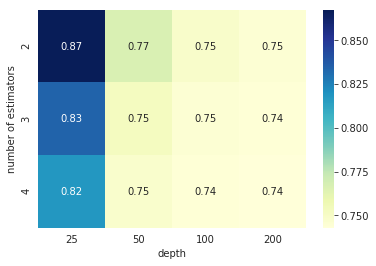

---------------------------------------------------------------------------
CV train mean_squared_errors


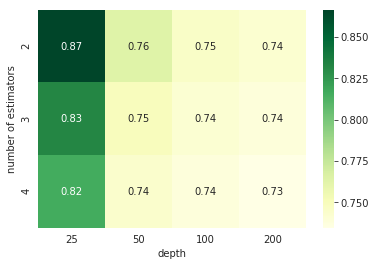

Train RMSE : 0.858
Train mape : 25.603


Test RMSE : 1.111
Test mape : 34.141


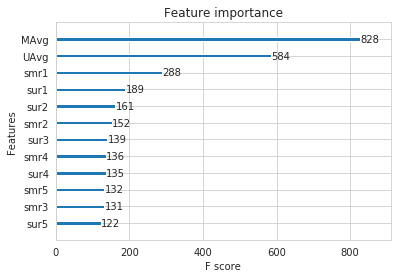

In [56]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

x_train = train.drop(['user','movie','rating'], axis=1)
y_train = train['rating']

x_test = test.drop(['user','movie','rating'], axis=1)
y_test = test['rating']

tuned_parameters={
    'max_depth' : [2,3,4],
    'n_estimators': [25,50,100,200],
    'learning_rate':[0.1],
    'booster':['gbtree'],
    'n_jobs':[-1],
}

xgb_model = xgb.XGBRegressor()
model = GridSearchCV(xgb_model, tuned_parameters, scoring = 'neg_mean_squared_error', cv=5,n_jobs=1,return_train_score =True)
model.fit(x_train,y_train)
print(model.best_estimator_)

print("-"*75)
print("CV test mean_squared_errors")

cv_scores = pd.DataFrame(model.cv_results_)

matri = np.asarray(-cv_scores['mean_test_score'])
matri = np.reshape(matri,newshape=(3,4))
matri = pd.DataFrame(matri,index=[2,3,4],columns=[25,50,100,200])

sns.heatmap(matri,annot=True,cmap="YlGnBu")
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.show()


print("-"*75)

print("CV train mean_squared_errors")

matri = np.asarray(-cv_scores['mean_train_score'])
matri = np.reshape(matri,newshape=(3,4))
matri = pd.DataFrame(matri,index=[2,3,4],columns=[25,50,100,200])

sns.heatmap(matri,annot=True,cmap="YlGn")
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.show()

y_pred = model.best_estimator_.predict(x_train)

train_rmse, train_mape = get_error_metrics(y_train,y_pred)

print("Train RMSE :",np.round(train_rmse,decimals=3))
print("Train mape :",np.round(train_mape,decimals=3))
print("\n")

y_pred = model.best_estimator_.predict(x_test)

test_rmse, test_mape = get_error_metrics(y_test,y_pred)

print("Test RMSE :",np.round(test_rmse,decimals=3))
print("Test mape :",np.round(test_mape,decimals=3))

models_evaluation_train['rmse'] = train_rmse
models_evaluation_train['mape'] = train_mape
models_evaluation_test['rmse'] = test_rmse
models_evaluation_test['mape'] = test_mape

xgb.plot_importance(model.best_estimator_)

plt.show()

In [57]:
import pickle as pkl

with open("model_1.pkl",'wb') as f:
    pkl.dump([y_pred],f)

<h3> Suprise BaselineModel </h3>

In [58]:
from surprise import BaselineOnly 

bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
my_bsl_algo = BaselineOnly(bsl_options=bsl_options)
bsl_train_results, bsl_test_results = run_surprise(my_bsl_algo, trainset, testset, verbose=True)


models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Estimating biases using sgd...
---------------
Train Data
---------------
RMSE : 0.9222357942097669

MAPE : 28.587344935763692

---------------
Test Data
---------------
RMSE : 1.0867874836763205

MAPE : 35.008478789701776



<h3>  XGBoost with initial 13 features + Surprise Baseline predictor </h3>

In [59]:
# add our baseline_predicted value as our feature..
train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
test['bslpr']  = models_evaluation_test['bsl_algo']['predictions']
train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,1269389,9628,3.587581,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,3.0,3.529412,4.480237,5,4.399871
1,1270541,9628,3.587581,5.0,3.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4.090909,4.480237,5,3.326096


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
---------------------------------------------------------------------------
CV test mean_squared_errors


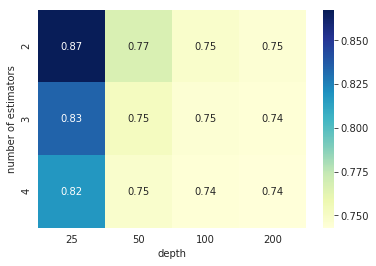

---------------------------------------------------------------------------
CV train mean_squared_errors


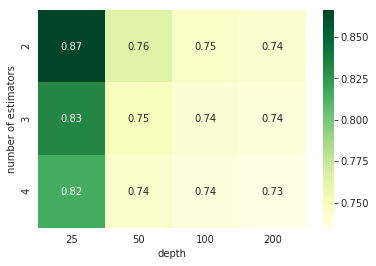

Train RMSE : 0.858
Train mape : 25.608


Test RMSE : 1.115
Test mape : 34.023


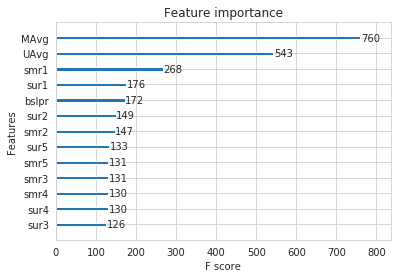

In [60]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

x_train = train.drop(['user','movie','rating'], axis=1)
y_train = train['rating']

x_test = test.drop(['user','movie','rating'], axis=1)
y_test = test['rating']

tuned_parameters={
    'max_depth' : [2,3,4],
    'n_estimators': [25,50,100,200],
    'learning_rate':[0.1],
    'booster':['gbtree'],
    'n_jobs':[-1],
}

xgb_model = xgb.XGBRegressor()
model = GridSearchCV(xgb_model, tuned_parameters, scoring = 'neg_mean_squared_error', cv=5,n_jobs=1,return_train_score =True)
model.fit(x_train,y_train)
print(model.best_estimator_)

print("-"*75)
print("CV test mean_squared_errors")

cv_scores = pd.DataFrame(model.cv_results_)

matri = np.asarray(-cv_scores['mean_test_score'])
matri = np.reshape(matri,newshape=(3,4))
matri = pd.DataFrame(matri,index=[2,3,4],columns=[25,50,100,200])

sns.heatmap(matri,annot=True,cmap="YlGnBu")
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.show()


print("-"*75)

print("CV train mean_squared_errors")

matri = np.asarray(-cv_scores['mean_train_score'])
matri = np.reshape(matri,newshape=(3,4))
matri = pd.DataFrame(matri,index=[2,3,4],columns=[25,50,100,200])

sns.heatmap(matri,annot=True,cmap="YlGn")
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.show()

y_pred = model.best_estimator_.predict(x_train)

train_rmse, train_mape = get_error_metrics(y_train,y_pred)

print("Train RMSE :",np.round(train_rmse,decimals=3))
print("Train mape :",np.round(train_mape,decimals=3))
print("\n")

y_pred = model.best_estimator_.predict(x_test)

test_rmse, test_mape = get_error_metrics(y_test,y_pred)

print("Test RMSE :",np.round(test_rmse,decimals=3))
print("Test mape :",np.round(test_mape,decimals=3))


xgb.plot_importance(model.best_estimator_)

plt.show()

<h3>  Surprise KNNBaseline predictors </h3>

 <h4> Surprise KNNBaseline with user user similarities</h4>

In [61]:
from surprise import KNNBaseline

sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
bsl_options = {'method': 'sgd'} 


knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset)

models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------
Train Data
---------------
RMSE : 0.45539042929013207

MAPE : 12.903089795831729

---------------
Test Data
---------------
RMSE : 1.0871488949926553

MAPE : 35.01626035427996



<h4> Surprise KNNBaseline with movie movie similarities</h4>

In [62]:
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
---------------
Train Data
---------------
RMSE : 0.50797091418216

MAPE : 14.282213909399125

---------------
Test Data
---------------
RMSE : 1.0874168180719535

MAPE : 35.0190834427918



<h3> XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictors </h3>

In [63]:
# add the predicted values from both knns to this dataframe
train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

test['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
test['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']


train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,1269389,9628,3.587581,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,3.0,3.529412,4.480237,5,4.399871,4.782176,4.900055
1,1270541,9628,3.587581,5.0,3.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4.090909,4.480237,5,3.326096,2.984534,2.870883


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
---------------------------------------------------------------------------
CV test mean_squared_errors


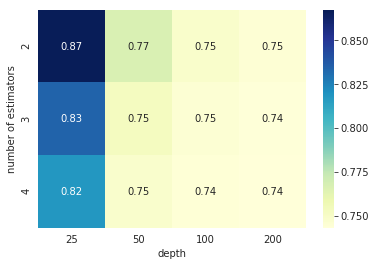

---------------------------------------------------------------------------
CV train mean_squared_errors


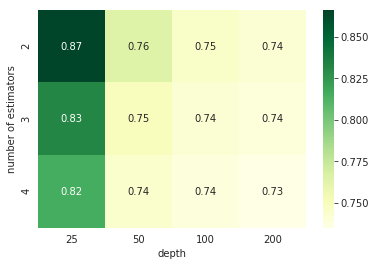

Train RMSE : 0.858
Train mape : 25.612


Test RMSE : 1.113
Test mape : 34.103


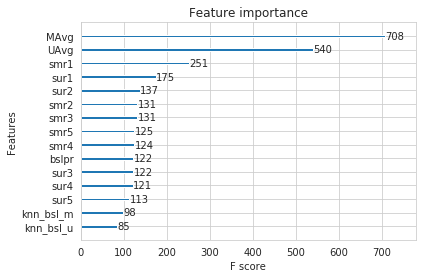

In [66]:
from sklearn.model_selection import GridSearchCV


x_train = train.drop(['user','movie','rating'], axis=1)
y_train = train['rating']

x_test = test.drop(['user','movie','rating'], axis=1)
y_test = test['rating']

tuned_parameters={
    'max_depth' : [2,3,4],
    'n_estimators': [25,50,100,200],
    'learning_rate':[0.1],
    'booster':['gbtree'],
    'n_jobs':[-1],
}

xgb_model = xgb.XGBRegressor()
model = GridSearchCV(xgb_model, tuned_parameters, scoring = 'neg_mean_squared_error', cv=5,n_jobs=1,return_train_score =True)
model.fit(x_train,y_train)
print(model.best_estimator_)

print("-"*75)
print("CV test mean_squared_errors")

cv_scores = pd.DataFrame(model.cv_results_)

matri = np.asarray(-cv_scores['mean_test_score'])
matri = np.reshape(matri,newshape=(3,4))
matri = pd.DataFrame(matri,index=[2,3,4],columns=[25,50,100,200])

sns.heatmap(matri,annot=True,cmap="YlGnBu")
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.show()


print("-"*75)

print("CV train mean_squared_errors")

matri = np.asarray(-cv_scores['mean_train_score'])
matri = np.reshape(matri,newshape=(3,4))
matri = pd.DataFrame(matri,index=[2,3,4],columns=[25,50,100,200])

sns.heatmap(matri,annot=True,cmap="YlGn")
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.show()

y_pred = model.best_estimator_.predict(x_train)

train_rmse, train_mape = get_error_metrics(y_train,y_pred)

print("Train RMSE :",np.round(train_rmse,decimals=3))
print("Train mape :",np.round(train_mape,decimals=3))
print("\n")

y_pred = model.best_estimator_.predict(x_test)

test_rmse, test_mape = get_error_metrics(y_test,y_pred)

print("Test RMSE :",np.round(test_rmse,decimals=3))
print("Test mape :",np.round(test_mape,decimals=3))


xgb.plot_importance(model.best_estimator_)

plt.show()

<h3> Matrix Factorization Techniques </h3>

<h4> SVD Matrix Factorization User Movie intractions </h4>

In [67]:
from surprise import SVD
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

---------------
Train Data
---------------
RMSE : 0.6752601909489298

MAPE : 20.024520399720103

---------------
Test Data
---------------
RMSE : 1.0867994936143073

MAPE : 34.94318162987993



<h4> SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [68]:
from surprise import SVDpp

svdpp = SVDpp(n_factors=50, random_state=15)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

---------------
Train Data
---------------
RMSE : 0.6643101697111403

MAPE : 19.300015364841776

---------------
Test Data
---------------
RMSE : 1.086935350886891

MAPE : 34.901354875110506



<h3> XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

In [70]:
train['svd'] = models_evaluation_train['svd']['predictions']
train['svdpp'] = models_evaluation_train['svdpp']['predictions']

test['svd'] = models_evaluation_test['svd']['predictions']
test['svdpp'] = models_evaluation_test['svdpp']['predictions']
train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1269389,9628,3.587581,4.0,5.0,4.0,5.0,4.0,4.0,5.0,...,4.0,3.0,3.529412,4.480237,5,4.399871,4.782176,4.900055,4.615341,4.622453
1,1270541,9628,3.587581,5.0,3.0,4.0,4.0,4.0,5.0,5.0,...,4.0,4.0,4.090909,4.480237,5,3.326096,2.984534,2.870883,3.059331,2.845559


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
---------------------------------------------------------------------------
CV test mean_squared_errors


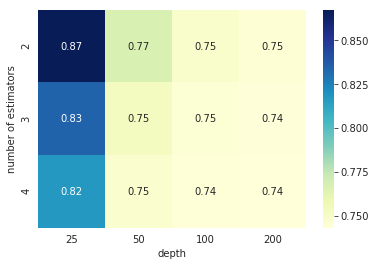

---------------------------------------------------------------------------
CV train mean_squared_errors


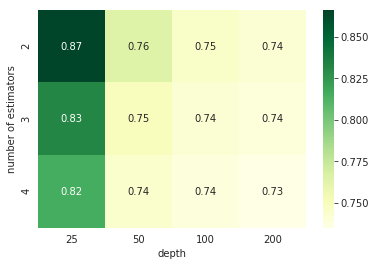

Train RMSE : 0.858
Train mape : 25.613


Test RMSE : 1.113
Test mape : 34.101


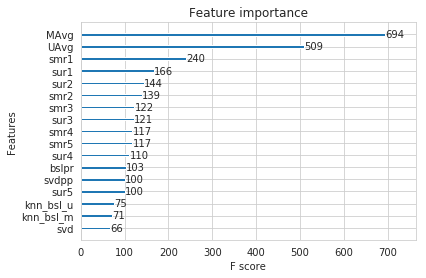

In [71]:
x_train = train.drop(['user','movie','rating'], axis=1)
y_train = train['rating']

x_test = test.drop(['user','movie','rating'], axis=1)
y_test = test['rating']

tuned_parameters={
    'max_depth' : [2,3,4],
    'n_estimators': [25,50,100,200],
    'learning_rate':[0.1],
    'booster':['gbtree'],
    'n_jobs':[-1],
}

xgb_model = xgb.XGBRegressor()
model = GridSearchCV(xgb_model, tuned_parameters, scoring = 'neg_mean_squared_error', cv=5,n_jobs=1,return_train_score =True)
model.fit(x_train,y_train)
print(model.best_estimator_)

print("-"*75)
print("CV test mean_squared_errors")

cv_scores = pd.DataFrame(model.cv_results_)

matri = np.asarray(-cv_scores['mean_test_score'])
matri = np.reshape(matri,newshape=(3,4))
matri = pd.DataFrame(matri,index=[2,3,4],columns=[25,50,100,200])

sns.heatmap(matri,annot=True,cmap="YlGnBu")
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.show()


print("-"*75)

print("CV train mean_squared_errors")

matri = np.asarray(-cv_scores['mean_train_score'])
matri = np.reshape(matri,newshape=(3,4))
matri = pd.DataFrame(matri,index=[2,3,4],columns=[25,50,100,200])

sns.heatmap(matri,annot=True,cmap="YlGn")
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.show()

y_pred = model.best_estimator_.predict(x_train)

train_rmse, train_mape = get_error_metrics(y_train,y_pred)

print("Train RMSE :",np.round(train_rmse,decimals=3))
print("Train mape :",np.round(train_mape,decimals=3))
print("\n")

y_pred = model.best_estimator_.predict(x_test)

test_rmse, test_mape = get_error_metrics(y_test,y_pred)

print("Test RMSE :",np.round(test_rmse,decimals=3))
print("Test mape :",np.round(test_mape,decimals=3))


xgb.plot_importance(model.best_estimator_)

plt.show()

<h3> XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
---------------------------------------------------------------------------
CV test mean_squared_errors


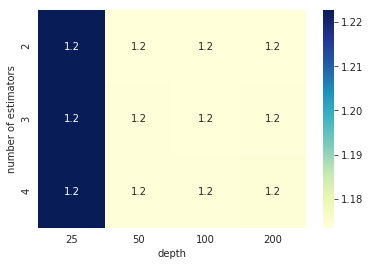

---------------------------------------------------------------------------
CV train mean_squared_errors


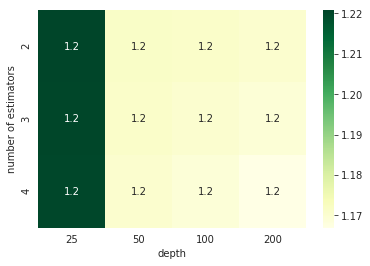

Train RMSE : 1.082
Train mape : 35.583


Test RMSE : 1.097
Test mape : 35.579


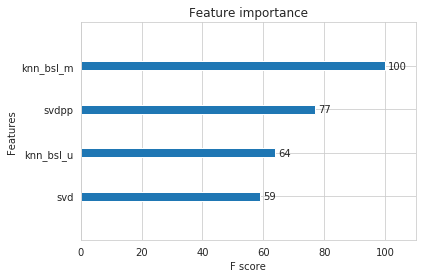

In [72]:
x_train = train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = train['rating']

x_test = test[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = test['rating']

tuned_parameters={
    'max_depth' : [2,3,4],
    'n_estimators': [25,50,100,200],
    'learning_rate':[0.1],
    'booster':['gbtree'],
    'n_jobs':[-1],
}

xgb_model = xgb.XGBRegressor()
model = GridSearchCV(xgb_model, tuned_parameters, scoring = 'neg_mean_squared_error', cv=5,n_jobs=1,return_train_score =True)
model.fit(x_train,y_train)
print(model.best_estimator_)

print("-"*75)
print("CV test mean_squared_errors")

cv_scores = pd.DataFrame(model.cv_results_)

matri = np.asarray(-cv_scores['mean_test_score'])
matri = np.reshape(matri,newshape=(3,4))
matri = pd.DataFrame(matri,index=[2,3,4],columns=[25,50,100,200])

sns.heatmap(matri,annot=True,cmap="YlGnBu")
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.show()


print("-"*75)

print("CV train mean_squared_errors")

matri = np.asarray(-cv_scores['mean_train_score'])
matri = np.reshape(matri,newshape=(3,4))
matri = pd.DataFrame(matri,index=[2,3,4],columns=[25,50,100,200])

sns.heatmap(matri,annot=True,cmap="YlGn")
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.show()

y_pred = model.best_estimator_.predict(x_train)

train_rmse, train_mape = get_error_metrics(y_train,y_pred)

print("Train RMSE :",np.round(train_rmse,decimals=3))
print("Train mape :",np.round(train_mape,decimals=3))
print("\n")

y_pred = model.best_estimator_.predict(x_test)

test_rmse, test_mape = get_error_metrics(y_test,y_pred)

print("Test RMSE :",np.round(test_rmse,decimals=3))
print("Test mape :",np.round(test_mape,decimals=3))


xgb.plot_importance(model.best_estimator_)

plt.show()

# Conclusion

In [2]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names =['Featurization','Model','Hyper-parameters','RMSE','MAPE']

x.add_row(['Handcrafted 13 features\n\n','XGBoost Regressor',' max_depth : 4 \n n_estimators: 200 \n learning rate =0.1\n','1.111','34.141',])

x.add_row(['Surprise features\n','Surprise Baseline','method: sgd \n learning_rate : .001\n','1.0867','35.008'])

x.add_row(['Handcrafted 13 features \n+ Surprise Baseline predictor as a feature\n','XGBoost Regressor',' max_depth : 4 \n n_estimators: 200 \n learning rate =0.1\n','1.115','34.023',])

x.add_row(['Surprise features\n','Surprise KNNBaseline','user_based : True \nname: pearson_baseline \nshrinkage: 100\nmin_support : 2\n','1.087','35.016'])

x.add_row(['Surprise features\n','Surprise KNNBaseline','user_based : False \nname: pearson_baseline \nshrinkage: 100\nmin_support : 2\n','1.087','35.019'])

x.add_row(['Handcrafted 13 features \n+ Surprise Baseline predictor as a feature\n+ Surprise KNNBaseline predictors as features\n','XGBoost Regressor',' max_depth : 4 \n n_estimators: 200 \n learning rate =0.1\n','1.113','34.103',])

x.add_row(['Surprise features\n','SVD','n_factors=100\n','1.0867','34.943'])

x.add_row(['Surprise features\n','SVD++','n_factors=50\n','1.0869','34.90'])

x.add_row(['Surprise Baseline predictor as a feature\n+ Surprise KNNBaseline predictor as a feature\n+ Matrix Factorization Techniques\n','XGBoost Regressor',' max_depth : 4 \n n_estimators: 200 \n learning rate =0.1\n','1.097','35.579',])

x.add_row(['Handcrafted 13 features \n+ Surprise Baseline predictor as a feature\n+ Surprise KNNBaseline predictor as a feature\n+ Matrix Factorization Techniques\n','XGBoost Regressor','max_depth : 4 \n n_estimators: 200 \n learning rate =0.1\n','1.113','34.101',])

print(x)
print("* check procedure about the handcrafted 13 features.")

+-----------------------------------------------+----------------------+-------------------------+--------+--------+
|                 Featurization                 |        Model         |     Hyper-parameters    |  RMSE  |  MAPE  |
+-----------------------------------------------+----------------------+-------------------------+--------+--------+
|            Handcrafted 13 features            |  XGBoost Regressor   |      max_depth : 4      | 1.111  | 34.141 |
|                                               |                      |    n_estimators: 200    |        |        |
|                                               |                      |    learning rate =0.1   |        |        |
|                                               |                      |                         |        |        |
|               Surprise features               |  Surprise Baseline   |       method: sgd       | 1.0867 | 35.008 |
|                                               |               

# Procedure

* It was clear that the main objective for this bussiness problem was to predict the rating that a user would give to a movie that he/she has not yet rated.

* Extracted the data from the four different text files to a single csv file.

* Pre-processed the data.

* Analysed the ratings given by user. 

* Analysed the ratings of a movie given by a user.

* Created the train and test sparse matrices from the data frame.

* Computed Movie-Movie Similarity matrix and found the most similar movies for a given movie.

* Sampled the train and test data considering the computational power.

* Represented the train and test data with 13 handcrafted features as:

    - __GAvg__ : Average rating of all the ratings .

    - __Similar users rating of this movie__:
        - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
   
    - __Similar movies rated by this user__:
        - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )

    - __UAvg__ : User's Average rating.

    - __MAvg__ : Average rating of this movie.

* Transformed the train and test data into Surprise features for Surprise models.

* Applied XGBoost on the 13 handcrafted features.

* Applied Surprise Baseline Model on Surprise features.

* Applied XGBoost on the 13 handcrafted features along with the rating predicted by the Surprise Baseline Model as a feature.

* Applied Surprise KNNBaseline Models on Surprise features.

* Applied XGBoost on the 13 handcrafted features along with the ratings predicted by the Surprise Baseline Model and KNNBaseline Models as features.

* Applied Matrix Factorization Techniques like SVD and SVD++ on Surprise features.

* Applied XGBoost on the 13 handcrafted features along with the ratings predicted by the Surprise Baseline Model,KNNBaseline Models and Matrix Factorization Techniques as features.

*  Applied XGBoost on the ratings that are predicted by the Surprise Baseline Model,KNNBaseline Models and Matrix Factorization Techniques as features.

* Compared all the models using pretty table.